<a href="https://colab.research.google.com/github/robert-altdeep/causalML/blob/new-tutorials/causal_decision_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

©2021, Altdeep, Inc. All rights   Visit Altdeep.ai for content related to this notebook.

In [ ]:
import networkx as nx
import pylab as plt

from pgmpy.models import BayesianNetwork as bn
from pgmpy.inference import BeliefPropagation, VariableElimination
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's consider a simple problem of advertising on an e-commerce website.  A user is exposed to an advertisement 'a' (X='a') or 'b' (X='b'). Users are distinguished by different "contexts" "C", meaning user background.  In this case, context just means age: young (C='young') and old (C='old').  They purchase a product (Y=1) or they don't (Y=1).  The causal DAG is as follows.

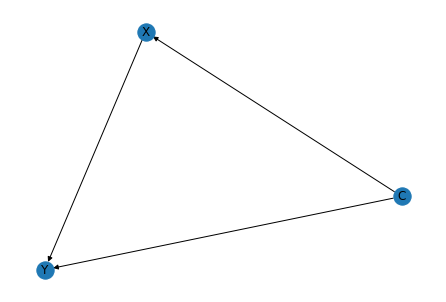

In [ ]:
model = bn()
model.add_edges_from(
    [
      ('C','X'),
      ('X','Y'),
      ('C','Y'),
    ]
)
nx.draw(model, with_labels=True)
plt.show()

Half the users are young and the other half are old.  So a given user has a 50-50 chance of being either.

In [ ]:
kernel_c = TabularCPD(
    'C', 2, [[.5], [.5]],
    state_names= {'C': ['young', 'old']}
)
print(kernel_c)

+----------+-----+
| C(young) | 0.5 |
+----------+-----+
| C(old)   | 0.5 |
+----------+-----+


Young people have a 2/3 chance of seeing advertisement 'a' and a 1/3 chance of of seeing the advertisement 'b'.  Old people have a 1/3 chance of seeing advertisement 'a' and a 2/3 chance of seeing advertisement 'b'.

In [ ]:
kernel_x = TabularCPD('X', 2, [[2/3, 1/3], [1/3, 2/3]], 
                      evidence=['C'], evidence_card=[2],
                      state_names = {
                          'X': ['a', 'b'],
                          'C': ['young', 'old']
                      })
print(kernel_x)

+------+--------------------+--------------------+
| C    | C(young)           | C(old)             |
+------+--------------------+--------------------+
| X(a) | 0.6666666666666666 | 0.3333333333333333 |
+------+--------------------+--------------------+
| X(b) | 0.3333333333333333 | 0.6666666666666666 |
+------+--------------------+--------------------+


The probability an individual will buy the product depends on their age and which advertisement they purchased.

* Young people who have seen ad "a" have a 92.5% chance of buying.
* Young people who have seen ad "b" have a 95% chance of buying.
* Old people who have not seen ad "a" have a 60% chance of buying.
* Old people who have seen ad "b" have a 70% chance of buying.



In [ ]:
kernel_y = TabularCPD('Y', 2, 
                        [[ 0.075, 0.4, 0.05, 0.3], [0.925, 0.6, 0.95, 0.7]],
                        evidence=['X','C'], evidence_card=[2, 2],
                        state_names = {
                            'X': ['a', 'b'],
                            'C': ['young', 'old'],
                            'Y': [0, 1]
                        }
                      )
print(kernel_y)

+------+----------+--------+----------+--------+
| X    | X(a)     | X(a)   | X(b)     | X(b)   |
+------+----------+--------+----------+--------+
| C    | C(young) | C(old) | C(young) | C(old) |
+------+----------+--------+----------+--------+
| Y(0) | 0.075    | 0.4    | 0.05     | 0.3    |
+------+----------+--------+----------+--------+
| Y(1) | 0.925    | 0.6    | 0.95     | 0.7    |
+------+----------+--------+----------+--------+


We want to extend incorporate utility into this model.  So next, I add a utility node.

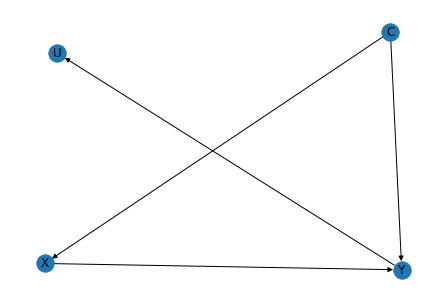

In [ ]:
model.add_edge('Y', 'U')
nx.draw(model, with_labels=True)
plt.show()

Let's quantify utility in dollars.  Assume an advertisement costs \$1.  A sale is \$10.  That leaves us with the following utility function $U(Y=0) = -1$ and $U(Y=1) = 9$.  We'll use the state names of the utility variable to encode the utility values.

In [ ]:
# 
kernel_u = TabularCPD(
    'U', 2, [[1,0], [0,1]], 
    evidence=['Y'], evidence_card=[2],
    state_names= {'U': [-1, 9], 'Y': [0, 1]})
print(kernel_u)

+-------+------+------+
| Y     | Y(0) | Y(1) |
+-------+------+------+
| U(-1) | 1.0  | 0.0  |
+-------+------+------+
| U(9)  | 0.0  | 1.0  |
+-------+------+------+


Finally, we create a generative model by adding the CPD's to the 

In [ ]:
model.add_cpds(kernel_c, kernel_x, kernel_y, kernel_u)

Let's define some functions to facilitate implementing causal decision theory.  

Firstly, let's modify pgmpy's `do` method so it is a `do`-operator, meaning a function that takes in a model, modifies it with an ideal intervention, and returns a new model.  Note that this code will need to be modified to work for continuous variables.

In [ ]:
def do(model, interventions):
    """ 
    Implement an ideal intervention for discrete variables.
    """
    def _mod_kernel(kernel, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """ 
        var_name = kernel.variable
        card = kernel.get_cardinality([var_name])[var_name]
        states = {kernel.get_state_names(var_name, i) for i in range(card)}
        non_int_states = states - {int_val,}
        prob_vals = [[1.0]] + [[0.0] for _ in range(card - 1)]
        intervention_kernel = TabularCPD(
            var_name, card, prob_vals,
            state_names = {var_name: [int_val] + list(non_int_states)}
        )
        return intervention_kernel

    kernels = {kern.variable: kern for kern in model.get_cpds()}
    new_model = model.copy()
    for var, int_val in interventions.items():
        new_model = new_model.do(var)
        new_kernel = _mod_kernel(kernels[var], int_val)
        new_model.add_cpds(new_kernel)
    return new_model


ints = {'X': 'a'}
intervention_model = do(model, ints)

print("Parents of X in original model:")
print(model.get_parents("X"))

print("Parents of X in intervention model:")
print(intervention_model.get_parents("X"))

print("CMK of X in original model:")
print(model.get_cpds(node="X"))

print("CMK of X in intervention model:")
print(intervention_model.get_cpds(node="X"))


Parents of X in original model:
['C']
Parents of X in intervention model:
[]
CMK of X in original model:
+------+--------------------+--------------------+
| C    | C(young)           | C(old)             |
+------+--------------------+--------------------+
| X(a) | 0.6666666666666666 | 0.3333333333333333 |
+------+--------------------+--------------------+
| X(b) | 0.3333333333333333 | 0.6666666666666666 |
+------+--------------------+--------------------+
CMK of X in intervention model:
+------+---+
| X(a) | 1 |
+------+---+
| X(b) | 0 |
+------+---+


Next let's define some functions for calculating expected utility.  `weighted_mean` calculates a weighted mean, which I'll use to calculate an expectation using `get_expected_utility`.  That calculates expected utility from an inference result produced by an inference algorithm like `VariableElimination` or `BeliefPropagation`.  That contains a `DiscreteFactor` object corresponding to the discrete conditional probability distribution of the utility outcomes.  Remember that I encoded the utility values as the state names of the utility variable, so the code retrieves those values to calculate the weighted average.

In [ ]:
def weighted_mean(vals, weights):
    # Calculate a weighted mean
    assert len(vals) == len(weights)
    norm = sum(weights)
    probs = [w/norm for w in weights]
    mean = sum(val * p for val, p in zip(vals, probs))
    return mean

def get_expected_utility(inference_result: DiscreteFactor, u_node: str="U"):
    utilities = inference_result.state_names[u_node]
    probs = inference_result.values
    return weighted_mean(utilities, probs)


`get_expected_utility_given_evidence` will take a model and some evidence (e.g. X = 'a') and calculate the expected utility.

In [ ]:
def get_expected_utility_given_evidence(model, evidence, u_node="U",
                                        inference_engine=VariableElimination):
    engine = inference_engine(model)
    inference_result = engine.query([u_node], evidence=evidence)
    expected_u = get_expected_utility(inference_result, u_node)
    return expected_u

However, to do causal decision theory, we want to reason with interventions because interventions are how we reason about the consequences of an action on utility.  So given a model and a set of interventions, `get_expected_utility_given_interventions` will transform the model with the ideal interventions, then calculate the expected utility on the transformed model.

In [ ]:
def get_expected_utility_given_interventions(model, interventions, u_node="U",
                                            inference_engine=VariableElimination):
    int_model = do(model, interventions)
    expected_u = get_expected_utility_given_evidence(
        int_model,
        evidence=interventions,
        u_node=u_node,
        inference_engine=inference_engine
    )
    return expected_u

get_expected_utility_given_interventions(model, interventions = {'X': 'a'})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

6.625

Next, we find which advertisement maximizes expected utility.  The following code shows that advertisement "b" is the optimal advertisement according to this decision rule.

In [ ]:
u_given_do_a = get_expected_utility_given_interventions(model, interventions = {'X': 'a'})
u_given_do_b = get_expected_utility_given_interventions(model, interventions = {'X': 'b'})
print("E(U|do(X=a)) = " + str(u_given_do_a) + "\n")
print("E(U|do(X=b)) = " + str(u_given_do_b) + "\n")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

E(U|do(X=a)) = 6.625

E(U|do(X=b)) = 7.25



Note the difference between maximizing E(U|do(X=x)) over x, and maximizing E(U|X=x) over x.  Advertisement "a" optimizes E(U|X=x)

In [ ]:
u_given_a = get_expected_utility_given_evidence(model, evidence = {'X': 'a'})
u_given_b = get_expected_utility_given_evidence(model, evidence = {'X': 'b'})
print("E(U|X=a) = " + str(u_given_a) + "\n")
print("E(U|X=b) = " + str(u_given_b) + "\n")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

E(U|X=a) = 7.166666666666666

E(U|X=b) = 6.833333333333333



This difference illustrates the advantage of causal decision theory.  E(U|X=x) fails to account for the confounding by the context variable, while E(U|do(X=x)) does not.

The causal semantics illustrated with the do-operator here are atypical in most pedagogical and applied settings.  Indeed, in economics or reinforcement learning, the solution to the problem of confounding in E(U|X=x) is to include confounding "covariates" like the context variable C in calculating utility, i.e., E(U|X=x, C=c).

Graph-based causal inference tells us that this is just a way of adjusting for confounders (backdoor adjustment).  Also, graph-based causal inference tells us what covariates *not* to adjust for lest we bias our decisions. For example, we don't adjust for nodes on the causal paths from action to utility (mediators) because doing so would block quantifying the action's effect on utility.  Similarly, we don't adjust for colliders between nodes on that path because that would induce collider bias.